In [18]:
import SL2P
from tools import read_sentinel2_safe_image
from tools import dictionariesSL2P 
from matplotlib import pyplot as plt
import os,numpy
import rasterio

### Initiation

In [7]:
variableName='LAI'
imageCollectionName="S2_SR"
fn = './testdata/S2B_MSIL2A_20230831T155829_N0509_R097_T18TVR_20230831T203613.SAFE' 

In [8]:
#### Input data Control ***-
if variableName not in dictionariesSL2P.make_net_options().keys():
    raise ValueError(('Supported vegetation valiables: %s'%(dictionariesSL2P.make_net_options().keys())))
if imageCollectionName not in dictionariesSL2P.make_net_options()[variableName].keys():
    raise ValueError(('Supported EO datasets: %s'%(dictionariesSL2P.make_net_options()[variableName].keys())))  
    
### Determine data resolution
RES=dictionariesSL2P.define_input_resolution()[imageCollectionName]

### 1- Read Sentinel-2 MSI/L2A image (.SAFE format)

In [23]:
s2=read_sentinel2_safe_image.read_s2(fn,res=RES)

Reading Sentinel-2 image


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s]


### 2- Prepare SL2P input data (11xNxM array): Surface reflectance (8- NxM layers) and acquisition geometry (3- NxM layers )

In [10]:
sl2p_inp=SL2P.prepare_sl2p_inp(s2,variableName,imageCollectionName)

Resample sun and view (sensor) angles
Scaling Sentinel-2 bands
Computing cosSZA, cosVZA and cosRAA
Selecting sl2p input bands
Done!


### 3- Run SL2P

In [28]:
varmap=SL2P.SL2P(sl2p_inp,variableName,imageCollectionName)

Generating sl2p input data flag
Run SL2P...
SL2P start: 2024-01-29 16:56:29.351010
SL2P end: 2024-01-29 16:56:40.047461
Generating sl2p output product flag
Done


### Export Sl2P product

In [27]:
ofn=fn.replace('.SAFE',variableName+'.tif')
profile=s2['profile']
profile.update({'count':4,'dtype':'float32','driver':'GTiff'}) 
with rasterio.open(ofn,'w',**profile) as dst:
    dst.write(varmap[variableName],1)
    dst.write(varmap[variableName+'_uncertainty'],2)
    dst.write(varmap['sl2p_inputFlag'],3)
    dst.write(varmap['sl2p_outputFlag'],4)

### 4- Show results 

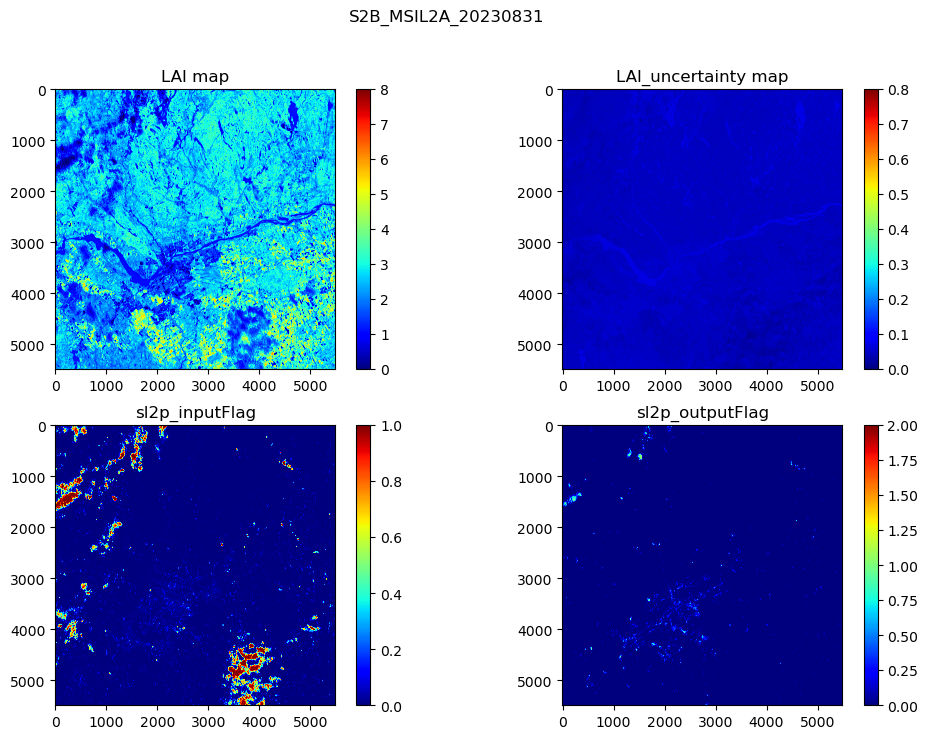

In [16]:
maxvar=dictionariesSL2P.make_outputParams()[variableName]['outputMax']

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(12,8))
fig.suptitle(os.path.split(fn)[-1][:19])

im1 = ax1.imshow(varmap[variableName],vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map')
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(varmap[variableName+'_uncertainty'],vmin=0,vmax=maxvar/10,cmap='jet')
ax2.set_title(variableName+'_uncertainty'+' map')
fig.colorbar(im2, ax=ax2, orientation='vertical')

im3 = ax3.imshow(varmap['sl2p_inputFlag'],vmin=0,vmax=1,cmap='jet')
ax3.set_title('sl2p_inputFlag')
fig.colorbar(im3, ax=ax3, orientation='vertical')

im4 = ax4.imshow(varmap['sl2p_outputFlag'],vmin=0,vmax=2,cmap='jet')
ax4.set_title('sl2p_outputFlag')
fig.colorbar(im4, ax=ax4, orientation='vertical')

### 5- Mask cloud, shadow, water ...

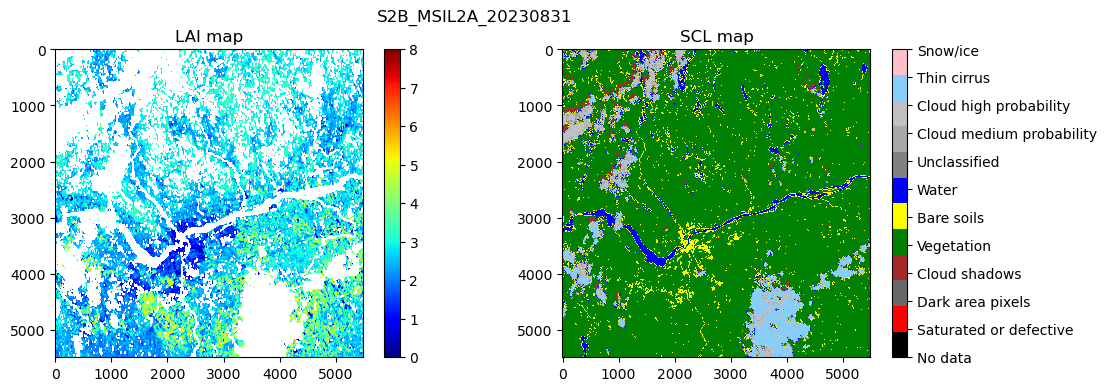

In [8]:
# Mask cloud, shadow, ....
from matplotlib.colors import ListedColormap
cmap =  ListedColormap(["black","red","dimgray","brown","green","yellow","Blue","gray","darkgray","silver","lightskyblue","pink"])
mask=numpy.where((s2['SCL']==4) | (s2['SCL']==5), 1, numpy.nan)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle(os.path.split(fn)[-1][:19])

im1 = ax1.imshow(varmap[variableName]*mask,vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map')
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(s2['SCL'],vmin=0,vmax=11,cmap=cmap)
ax2.set_title('SCL map')
cbar=fig.colorbar(im2, ax=ax2, ticks=numpy.linspace(0, 11, 12),orientation='vertical')
cbar.ax.set_yticklabels(['No data','Saturated or defective','Dark area pixels','Cloud shadows','Vegetation','Bare soils','Water','Unclassified','Cloud medium probability','Cloud high probability','Thin cirrus','Snow/ice']);

### 6- Comparaison with SL2P-SNAP version product  

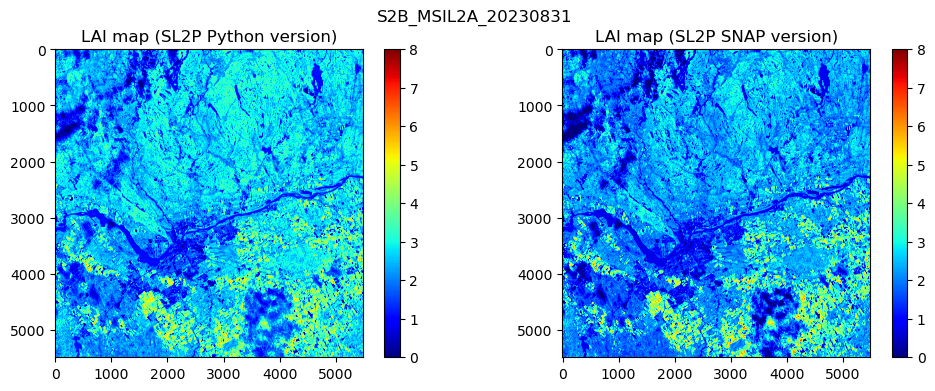

In [9]:
import rasterio

ref_path='./testdata/sl2p_snap_products/'
ref_fn=[ff for ff in os.listdir(ref_path) if variableName in ff][0]

with rasterio.open(ref_path+ref_fn) as rio:
    snap_sl2p_product=rio.read(1)
    
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle(os.path.split(fn)[-1][:19])

im1 = ax1.imshow(varmap[variableName],vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map (SL2P Python version)' )
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(snap_sl2p_product,vmin=0,vmax=maxvar,cmap='jet')
ax2.set_title(variableName+' map (SL2P SNAP version)')
fig.colorbar(im2, ax=ax2, orientation='vertical')